In [ ]:
#AllenNLP Library
!pip install  -U allennlp_models 

In [ ]:
!pip install pretty-confusion-matrix
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [40]:
from allennlp_models.pretrained import load_predictor
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, balanced_accuracy_score \
                            ,matthews_corrcoef, average_precision_score, precision_recall_curve, auc, plot_precision_recall_curve
from pretty_confusion_matrix import pp_matrix_from_data
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

In [41]:
#Model
model = load_predictor("pair-classification-roberta-snli")

#Exemple 
premise = "Two women are wandering along the shore drinking iced tea."
hypothesis = "Two women are sitting on a blanket near some rocks talking about politics."
preds = model.predict(premise,hypothesis)

Dataset for testing 

In [48]:
model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
#Je considère df_train comme étant données test à cause de faible de couple premise/hypothessis en français
df_test=pd.read_csv("/content/drive/MyDrive/contradictory-my-dear-watson/train.csv", sep=",")


In [80]:
 #Garder que l'anglais
df_test=df_test[df_test["language"]=="English"]

#Garder que les columns dont on a besoin
df_test.drop(columns = ['id', 'lang_abv','language'],axis = 1, inplace = True)

#On renomme
df_test.rename(columns = {'premise':'sentence1', 'hypothesis':'sentence2','label':'gold_label'}, inplace = True)
df_test = df_test.head(500)   

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [51]:
df_test

,sentence1,sentence2,gold_label
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,0
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2
3,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0
7,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2
8,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1
...,...,...,...
848,well i think that's about all my pet stories r...,"My pets are up to many antics, and I'm happy I...",1
849,"will never be doused (Brit Hume, Fox News Sund...",The man was criticized for not fully disclosin...,0
850,"As he stepped across the threshold, Tommy brou...",Tommy stepped across a threshold and put a pic...,0
851,"Then, all the time, it was in the spill vase i...",You mean to say it was stupid for us to look s...,1


In [82]:
df_test.groupby('gold_label').count()

,premise,hypothesis
gold_label,,
0,172,172
1,165,165
2,163,163


In [57]:
#l'ordre est important selon le model choisi 

label_mapping = ['entailment', 'contradiction', 'neutral']
premise  = df_test['sentence1'].values
hypothesis = df_test['sentence2'].values

In [58]:
# predictions pour le jeu de test 
listt = []
for i in range (len(hypothesis)):
  preds = model.predict(premise[i],hypothesis[i])
  labels = [label_mapping[score_max] for score_max in np.array([preds['logits']], dtype="float32").argmax(axis=1)]
  listt.append(labels)

In [ ]:
listt

In [ ]:
listt = [[0] if x == ['entailment'] else [1] if x == ['neutral'] else [2] for x in listt]
listt = np.array(listt)
listt = np.array(listt).reshape(-1)
listt

In [61]:
#transformer les données afin de calculer l'accuracy et la matrice de confusion 
le = LabelEncoder()
Y_test = np_utils.to_categorical(le.fit_transform(df_test["gold_label"].values)).astype("int64")

In [62]:
Y_predi = np_utils.to_categorical(le.fit_transform(listt)).astype("int64")

In [63]:
#Résultat accuracy
test_acc = (np.argmax(Y_predi, axis=1) == np.argmax(Y_test, axis=1)).sum()/Y_test.shape[0] * 100
print("Accuracy on test set is: "+str(test_acc),"%")

Accuracy on test set is: 83.8 %


In [69]:
df = pd.DataFrame({'set':['test'], 'accuracy':[test_acc]})
df

,set,accuracy
0,test,83.8


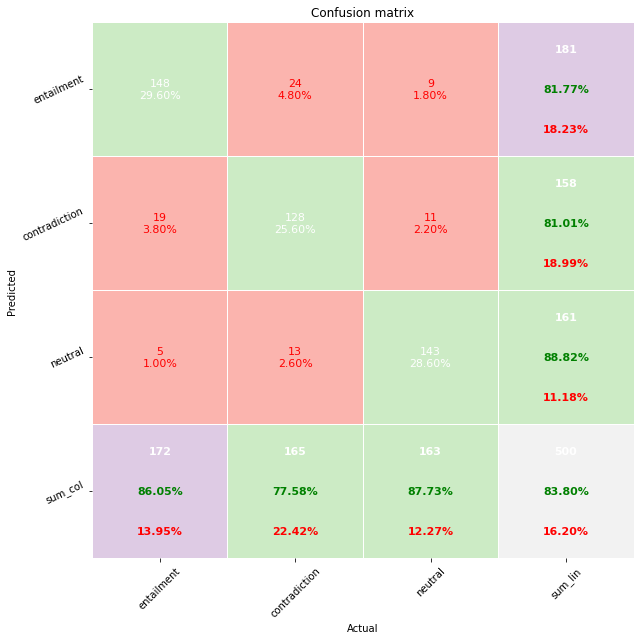

In [78]:
pp_matrix_from_data(Y_test, Y_predi, cmap='Pastel1',columns=['entailment', 'contradiction', 'neutral'],figsize=[6,6])


In [75]:
print(classification_report(Y_test, Y_predi))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       172
           1       0.81      0.78      0.79       165
           2       0.89      0.88      0.88       163

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500

